In [1]:
## Install required packages
# !pip install folium
# !pip install tensorflow_hub
# !pip install imageio
# !pip install selenium
# !pip install pdf
# !pip install imgkit
# !pip install --upgrade html2image
## Import necessary libraries
#file management
import os
import shutil
#rasterio
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
from rasterio import features
#geo
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
import imageio
#math
import numpy as np
import matplotlib.pyplot as plt
import math
import random
#visio
import cv2
import folium
from folium.plugins import MarkerCluster
from folium.vector_layers import PolyLine, Circle
from folium.vector_layers import PolyLine
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import IFrame
from PIL import Image
import imgkit
from html2image import Html2Image
from IPython import display
#ML
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from io import BytesIO

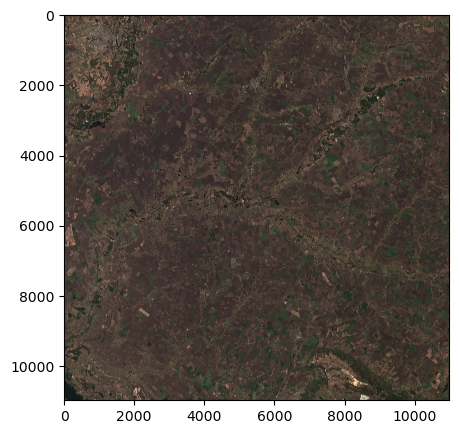

In [2]:
# Open the raster image with rasterio
raster_path = "C:\\Users\\Oleksii\\py\\Quantum\\Quantum internship\\T36UXV_20200406T083559_TCI_10m.jp2"
with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta
    
# Reshape the raster image
raster_img = reshape_as_image(raster_img)

# Display the raster image
plt.figure(figsize=(5,5))
plt.imshow(raster_img)

In [3]:
# Read the shapefile containing the mask polygons
train_df = gpd.read_file("C:\\Users\\Oleksii\\py\\Quantum\\Quantum internship\\masks\\Masks_T36UXV_20190427.shp")

# Remove rows without geometry
train_df = train_df[train_df.geometry.notnull()]

# assigning CRS
train_df.crs = 'epsg:4326'

#transforming polygons to the raster CRS
train_df = train_df.to_crs(raster_meta['crs']['init'])

In [4]:
# Open the raster image again with rasterio
src = rasterio.open(raster_path, 'r', driver="JP2OpenJPEG")

# Set the output folder paths
outfolder = "C:\\Users\\Oleksii\\py\\Quantum\\Quantum internship\\outfolder\\all_erosed"
train_erosed = "C:\\Users\\Oleksii\\py\\Quantum\\Quantum internship\\outfolder\\train_test_split\\train\\erosed"
test_erosed = "C:\\Users\\Oleksii\\py\\Quantum\\Quantum internship\\outfolder\\train_test_split\\test\\erosed"

# Create the output folders if they do not exist
os.makedirs(outfolder, exist_ok=True)
os.makedirs(train_erosed, exist_ok=True)
os.makedirs(test_erosed, exist_ok=True)

# Initialize empty lists to store failed and not failed polygons
failed = []
not_failed = []

# Loop through the mask polygons
for num, row in train_df.iterrows():
    try:
        # Mask the raster image with the polygon
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        # Reshape the masked image
        img_image = reshape_as_image(masked_image)
        # Set the output image path
        img_path = os.path.join(outfolder, str(num) + '.png')
        # Convert the RGB
        img_image = cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        # Save the image as PNG
        cv2.imwrite(img_path, img_image)
        not_failed.append(num)
    # If an error occurred, append the polygon index to the failed list
    except Exception as e:
        failed.append(num)
# Print the number of failed polygons
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 435 files


In [5]:
'''
It is surprising that almost half of the polygons in the eroded shapefile did not align with 
the raster image from Sentinel2. To investigate the issue, I will create an interactive map
that displays both the successful and unsuccessful polygons in blue and red colors, respectively.
'''

'\nIt is surprising that almost half of the polygons in the eroded shapefile did not align with \nthe raster image from Sentinel2. To investigate the issue, I will create an interactive map\nthat displays both the successful and unsuccessful polygons in blue and red colors, respectively.\n'

In [6]:
# Get a list of all PNG files in the outfolder directory
png_files = [f for f in os.listdir(outfolder) if f.endswith('.png')]

# Calculate the number of files to put in the train and test directories
num_files = len(png_files)
num_train = num_files // 2
num_test = num_files - num_train

# Shuffle the list of PNG files
random.shuffle(png_files)

# Copy the first half of the shuffled list to the train directory
for file in png_files[:num_train]:
    src_path = os.path.join(outfolder, file)
    dst_path = os.path.join(train_erosed, file)
    shutil.copyfile(src_path, dst_path)

# Copy the second half of the shuffled list to the test directory
for file in png_files[num_train:]:
    src_path = os.path.join(outfolder, file)
    dst_path = os.path.join(test_erosed, file)
    shutil.copyfile(src_path, dst_path)

In [7]:
# Read the original train dataframe that contains the polygons
train_df_orig = gpd.read_file("C:\\Users\\Oleksii\\py\\Quantum\\Quantum internship\\masks\\Masks_T36UXV_20190427.shp")

# Create empty dataframes to store the failed and not failed polygon coordinates
df = pd.DataFrame(columns=['id', 'lon', 'lat'])
df2 = pd.DataFrame(columns=['id', 'lon', 'lat'])

rows = []
rows2 = []

# Loop through the failed polygons and extract their coordinates
for a in failed:
    for b in range(len(train_df['geometry'][a].exterior.coords.xy[0])):
        id = a
        lon = train_df_orig['geometry'][a].exterior.coords.xy[0][b]
        lat = train_df_orig['geometry'][a].exterior.coords.xy[1][b]
        row = {'id':id, 'lon':lon, 'lat':lat}
        # Append the row dictionary to the list
        rows.append(row)

# Concatenate the rows to the DataFrame
df = pd.concat([df, pd.DataFrame(rows)])

# Loop through the not failed polygons and extract their coordinates
for a in not_failed:
    for b in range(len(train_df['geometry'][a].exterior.coords.xy[0])):
        id = a
        lon = train_df_orig['geometry'][a].exterior.coords.xy[0][b]
        lat = train_df_orig['geometry'][a].exterior.coords.xy[1][b]
        row = {'id':id, 'lon':lon, 'lat':lat}
        # Append the row dictionary to the list
        rows2.append(row)

# Concatenate the rows to the DataFrame
df2 = pd.concat([df2, pd.DataFrame(rows2)])
        

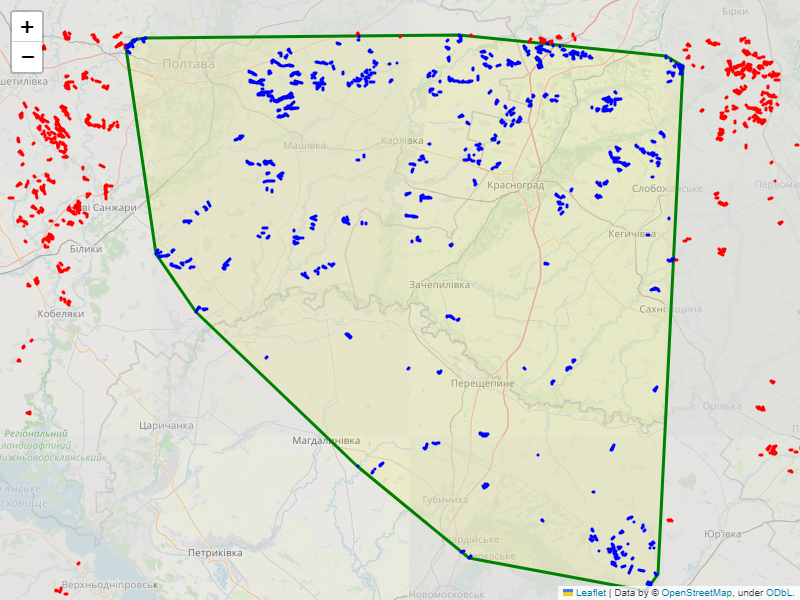

In [8]:
# create a map centered at the mean coordinates of the points
center_coords = (49.16776153762707, 35.130524612906186)
m = folium.Map(location=center_coords, zoom_start=9)

# Get all the points in the polygons
points = np.array(df2[['lat', 'lon']])

# Compute the convex hull
hull = ConvexHull(points)

# Get the center of the convex hull
hull_center = np.mean(points[hull.vertices, :], axis=0)

# Compute the maximum distance from the center to any point on the hull
hull_radius = np.max(np.linalg.norm(points[hull.vertices, :] - hull_center, axis=1))

# Draw the convex hull as a polygon
folium.Polygon(locations=points[hull.vertices, :].tolist(), color='green', fill=True, fill_color='yellow', fill_opacity=0.1).add_to(m)

# Iterate over unique ids in df and draw the polylines
for i in df['id'].unique():
    # get coordinates for the current id
    df_ = df[df['id'] == i]

    # create a polyline layer
    polyline = PolyLine(
        locations=df_[['lat', 'lon']].values.tolist(),
        color='red'
    ).add_to(m)

# Iterate over unique ids in df2 and draw the polygons inside the circle
for i in df2['id'].unique():
    # get coordinates for the current id
    df_ = df2[df2['id'] == i]
    points = np.array(df_[['lat', 'lon']])

    # check if all points are inside the circle
    if np.all(np.linalg.norm(points - hull_center, axis=1) <= hull_radius):
        # create a polygon layer
        polygon = folium.vector_layers.Polygon(
            locations=points.tolist(),
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.2
        ).add_to(m)
        
# Set the file paths for the input and output files
map_path = 'C:\\Users\\Oleksii\\py\\Quantum\\Quantum internship\\map.html'
img_path = 'C:\\Users\\Oleksii\\py\\Quantum\\map.png'

# Save the map as an HTML file
m.save(map_path)

# Use Html2Image to capture a screenshot of the HTML file and save it as a PNG file
hti = Html2Image()
hti.screenshot(
    html_file=map_path, 
    save_as='map.png'
)

# Display the resulting PNG file in the notebook
display.Image(img_path)


In [9]:
'''
It seems that almost half of the polygons (the red ones) are outside the boundary of the Sentinel2 image,
which is why the shapefile and jp2 file did not match up.
Fortunately, we can still use the blue polygons as labeled data for eroded soil. However, 
we don't have any examples of polygons representing non-eroded soil. To address this, we can generate such 
examples from the jp2 file.
Looking at the map, we can see that there is a large quadrant in the southwest with no eroded soil present. 
Let's visualize this area 
'''

"\nIt seems that almost half of the polygons (the red ones) are outside the boundary of the Sentinel2 image,\nwhich is why the shapefile and jp2 file did not match up.\nFortunately, we can still use the blue polygons as labeled data for eroded soil. However, \nwe don't have any examples of polygons representing non-eroded soil. To address this, we can generate such \nexamples from the jp2 file.\nLooking at the map, we can see that there is a large quadrant in the southwest with no eroded soil present. \nLet's visualize this area \n"

In [10]:
# Define the output directory path where the tiles will be saved
tile_path = 'C:\\Users\\Oleksii\\py\\Quantum\\Quantum internship\\outfolder\\tile'

# Create the output directory if it does not exist
os.makedirs(tile_path, exist_ok=True)

# Open the source raster image file for reading using rasterio
with rasterio.open(raster_path) as src:
    # Get the size of the source image
    width = src.width
    height = src.height
    
    # Define the tile size
    tile_size = 5000
    
    # Compute the number of tiles in the x and y directions
    num_tiles_x = math.ceil(width / tile_size)
    num_tiles_y = math.ceil(height / tile_size)
    
    # Loop over the tiles and extract them
    for j in range(num_tiles_y):
        for i in range(num_tiles_x):
            # Compute the window for the current tile
            window = rasterio.windows.Window(i*tile_size, j*tile_size, tile_size, tile_size)
            
            # Read the tile data as an array
            tile = src.read(window=window)
            
            # Convert the array to a Pillow image
            img = np.moveaxis(tile, 0, -1)
            
            # Save the image as a PNG file
            filename = f'{tile_path}\\tile_{i}_{j}.png'
            imageio.imwrite(filename, img)

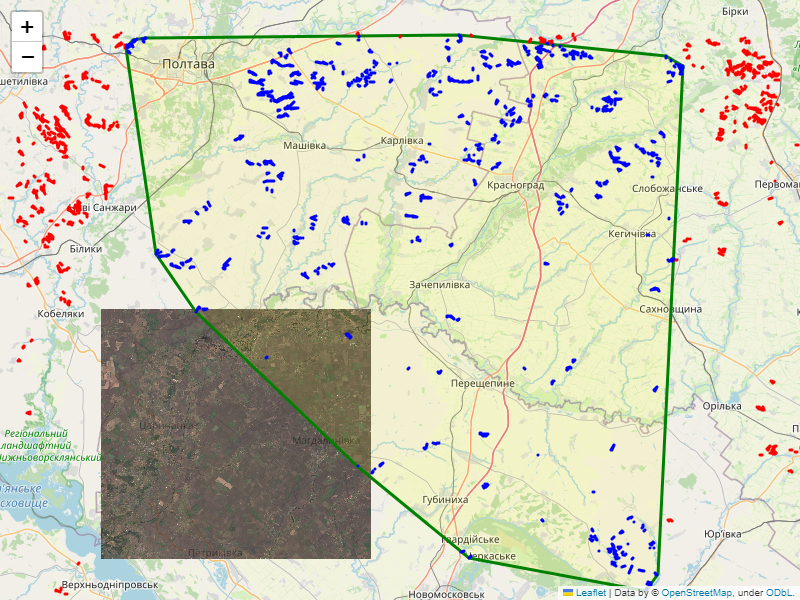

In [11]:
# specify the path to the PNG file and the bounding box coordinates for the image
image_path = 'C:\\Users\\Oleksii\\py\\Quantum\\Quantum internship\\outfolder\\tile\\tile_0_1.png'
image_bounds = [[49.150897605750544, 34.311288478708676], [48.69958111108647, 35.05131921072031]]

# create an ImageOverlay and add it to the map
image_overlay = folium.raster_layers.ImageOverlay(image_path, bounds=image_bounds, opacity=0.8)
image_overlay.add_to(m)

# Set the file paths for the input and output files
map_path = 'C:\\Users\\Oleksii\\py\\Quantum\\Quantum internship\\map2.html'
img_path = 'C:\\Users\\Oleksii\\py\\Quantum\\map2.png'

# Save the map as an HTML file
m.save(map_path)

# Use Html2Image to capture a screenshot of the HTML file and save it as a PNG file
hti = Html2Image()
hti.screenshot(
    html_file=map_path, 
    save_as='map2.png'
)

# Display the resulting PNG file in the notebook
display.Image(img_path)

In [12]:
'''We exctracted a tile without erosed polygons. Lets split it out to many small tiles and store them as 
labeled data for future ML model'''

'We exctracted a tile without erosed polygons. Lets split it out to many small tiles and store them as \nlabeled data for future ML model'

In [13]:
# Load the tile from the specified file path
img = cv2.imread('C:\\Users\\Oleksii\\py\\Quantum\\Quantum internship\\outfolder\\tile\\tile_0_1.png', cv2.IMREAD_UNCHANGED)

# Set up paths for output directories
outfolder = "C:\\Users\\Oleksii\\py\\Quantum\\Quantum internship\\outfolder\\all_not_erosed"
train_not_erosed = "C:\\Users\\Oleksii\\py\\Quantum\\Quantum internship\\outfolder\\train_test_split\\train\\not_erosed"
test_not_erosed = "C:\\Users\\Oleksii\\py\\Quantum\\Quantum internship\\outfolder\\train_test_split\\test\\not_erosed"
os.makedirs(outfolder, exist_ok=True)
os.makedirs(train_not_erosed, exist_ok=True)
os.makedirs(test_not_erosed, exist_ok=True)

# Define the size of the sub-images (100x100 pixels)
sub_img_width, sub_img_height = 50, 50

# Get the size of the large image
img_height, img_width = img.shape[:2]

# Loop over the image and extract sub-images
for i in range(0, img_height, sub_img_height):
    for j in range(0, img_width, sub_img_width):
        # Calculate the coordinates of the sub-image
        x, y = j, i
        w, h = sub_img_width, sub_img_height
        # Extract the sub-image
        sub_img = img[y:y+h, x:x+w]
        # Save the sub-image to a file
        out_file = os.path.join(outfolder, f"sub_{x}_{y}.png")
        cv2.imwrite(out_file, sub_img)
        
# get a list of all the PNG files in the input directory
all_files = os.listdir(outfolder)
png_files = [f for f in all_files if f.endswith('.png')]

# randomly select 250 files for the training set and 250 files for the test set
train_files = random.sample(png_files, 250)
test_files = random.sample(set(png_files) - set(train_files), 250)

# copy the training files to the train_not_erosed directory
for f in train_files:
    src_path = os.path.join(outfolder, f)
    dst_path = os.path.join(train_not_erosed, f)
    shutil.copy(src_path, dst_path)

# copy the test files to the test_not_erosed directory
for f in test_files:
    src_path = os.path.join(outfolder, f)
    dst_path = os.path.join(test_not_erosed, f)
    shutil.copy(src_path, dst_path)

C:\Users\Oleksii\AppData\Local\Temp\ipykernel_4248\2175781688.py:36: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  test_files = random.sample(set(png_files) - set(train_files), 250)


In [14]:
""""
So far we have generated two datasets: "train" and test". And each dataset consists of two subsets: "erosed" and "not erosed".
Each subset amounts to 250 files. Time to build a model!
But there is an issue - datasets are to small for ML modeling. In such a case "Transfer learning" approach seems to 
be the best option, since such ML models are trained on much greater datasets. 
Since it is an image classification problem, let's choose "resnet_v2_50" model.
"""

'"\nSo far we have generated two datasets: "train" and test". And each dataset consists of two subsets: "erosed" and "not erosed".\nEach subset amounts to 250 files. Time to build a model!\nBut there is an issue - datasets are to small for ML modeling. In such a case "Transfer learning" approach seems to \nbe the best option, since such ML models are trained on much greater datasets. \nSince it is an image classification problem, let\'s choose "resnet_v2_50" model.\n'

In [15]:
# Import necessary libraries
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the URL of the pre-trained ResNet-50 model
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'


# Set the target image shape and batch size
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# Set the paths of the training and test directories
train_dir = "C:\\Users\\Oleksii\\py\\Quantum\\Quantum internship\\outfolder\\train_test_split\\train"
test_dir = "C:\\Users\\Oleksii\\py\\Quantum\\Quantum internship\\outfolder\\train_test_split\\test"

# Create an image data generator for the data, with normalization
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Create a generator for data, which reads image files and generates 
#batches of augmented images to feed into the model.
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [16]:
# Create a model with a pre-trained feature extraction layer and a new output laye
def create_model(model_url, num_classes=2):
    # Load the pre-trained model as a KerasLayer from the given URL
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False, # freeze the underlying patterns
                                             name='feature_extraction_layer',
                                             input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

      # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer, # use the feature extraction layer as the base
        layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
      ])

    return model

In [17]:
# Create a model using the ResNet50 V2 feature extraction layer
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

# Compile the model with categorical cross-entropy loss function, Adam optimizer and accuracy metric
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
#Train the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))

Epoch 1/5
16/16 [==============================] - 39s 2s/step - loss: 0.2933 - accuracy: 0.8840 - val_loss: 0.0526 - val_accuracy: 0.9940
Epoch 2/5
16/16 [==============================] - 37s 2s/step - loss: 0.0330 - accuracy: 0.9980 - val_loss: 0.0189 - val_accuracy: 1.0000
Epoch 3/5
16/16 [==============================] - 38s 2s/step - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.0126 - val_accuracy: 1.0000
Epoch 4/5
16/16 [==============================] - 43s 3s/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 5/5
16/16 [==============================] - 56s 4s/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 1.0000


In [19]:
def plot_loss_curves(history):
    # Extract the training and validation loss values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Extract the training and validation accuracy values from the history object
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Create an array of epochs to use as the x-axis in the plots
    epochs = range(len(history.history['loss']))

    # Plot the training and validation loss values
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Create a new figure and plot the training and validation accuracy values
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

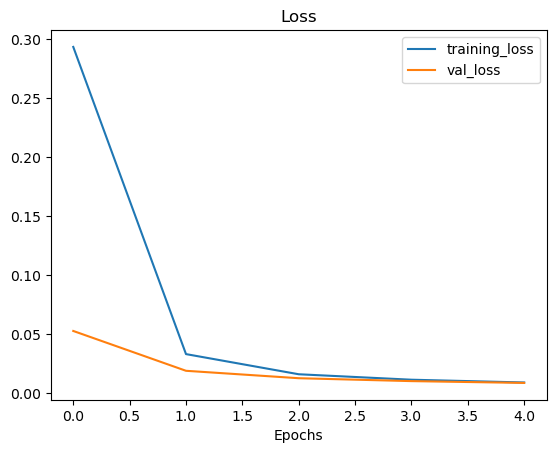

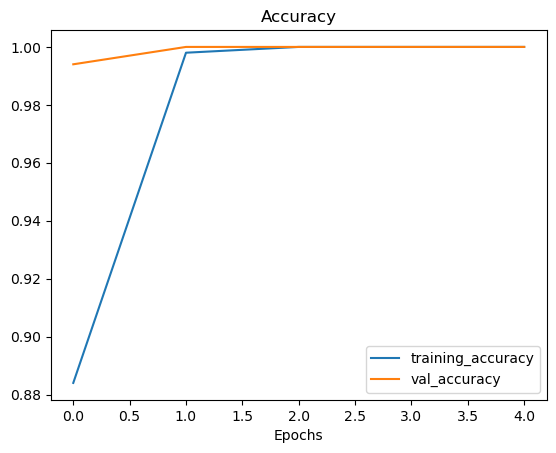

In [20]:
# Visualize the training and validation loss and accuracy of a model over epochs
plot_loss_curves(resnet_history)

In [21]:
"""
It seems that the model is suffering from overfitting. 
One way to solve this issue is to decrease the complexity of the model, incorporate more regularization techniques, 
or increase the amount of training data.
"""

'\nIt seems that the model is suffering from overfitting. \nOne way to solve this issue is to decrease the complexity of the model, incorporate more regularization techniques, \nor increase the amount of training data.\n'